In [1]:
import os
os.chdir('GPT4/pointer_analysis/GPT4')
print(os.getcwd())

/ChatGPT_analysis_latest/GPT4/pointer_analysis/GPT4


In [10]:
import os
import re
import json
from sklearn.metrics import jaccard_score
import re

res = []

os.makedirs("GPT4/output_acc", exist_ok=True)
os.makedirs("GPT4/output_others", exist_ok=True)
output_folder = "GPT4/output_acc"
output_other_folder = "GPT4/output_others" # chat gpt output wrong formats


frama_folder = "frama"
chatgpt_folder = "chatgpt"

# [eva:final-states] Values at end of function
def check_data(frama_folder, chatgpt_folder):
    for fname in os.listdir(frama_folder):
        of = f"{output_folder}/{fname}.sum"
        if not os.path.isfile(of):
            of = f"{output_other_folder}/{fname}.sum"
        else:
            print(of)
            continue
        with open(of, "w") as f:
        # f.write("Chat GPT ************************** \n ")
            fpath = os.path.join(frama_folder, fname)
            d = fname.replace(".c.txt", "")
            answer_md = os.path.join(chatgpt_folder, d, "gpt4_answer.md")
            code_txt = os.path.join(chatgpt_folder, d, "code.txt")
            try:
                answer_chat = json.load(open(answer_md))
            except:
                continue
            data = open(fpath).readlines()
            code = open(code_txt).read()
            answer_text_chatgpt = open(answer_md).read()
            answer_v = {}
            last_v = ""
            for l in data:
                if l.startswith("[eva:final-states] Values at end of function"):
                    f.write(l)

                if "∈" in l:
                    f.write(l)
                    l = l.strip()
                    cc = l.split("∈")
                    v = cc[0].strip().split()[-1]
                    alphabets = re.findall(r'[a-zA-Z]+', v)
                   # print(alphabets)
                    if len(alphabets) == 0 or v.strip().startswith(".") or v.strip().startswith("["):
                        alphabets = re.findall(r'[a-zA-Z]+', last_v)
                        tmpname = re.sub(r'(\[\d+\])+', "", last_v).strip()
                        v = tmpname+v.strip()
                    else:
                        last_v = v
                    
                    if "or" in cc[1]:
                        cc[1] = cc[1].split("or")[0]
                    # Use regular expression to extract only alphabets
                    alphabets = re.findall(r'[a-zA-Z]+', cc[1])
                    answer_v[v] = alphabets
            f.write(" \n  ************************** ChatGPT  ************************** \n ")    
            f.write(answer_text_chatgpt)    
            f.write(" \n ************************** Frama-c ************************** \n ")    
            if "__retres" in answer_v:
                del answer_v["__retres"]
            answer_v =  json.dumps(answer_v, indent=4 )
            f.write(answer_v)
            f.write(" \n \n Code ************************** \n ")  
            f.write(code)    
           # print(fname)
           # print(answer_v)    


In [11]:
check_data(frama_folder, chatgpt_folder)

In [12]:
import numpy as np
def are_dicts_equal(dict1, dict2):
    """Checks if two dictionaries are equal"""
    if len(dict1) != len(dict2):
        return False

    for key, value in dict1.items():
        if key not in dict2 or set(dict2[key]) != set(value):
            return False

    return True

def jaccard_similarity(a, b):
    # convert to set
    a = set(a)
    b = set(b)
    # calucate jaccard similarity
    try:
        j = float(len(a.intersection(b))) / len(a.union(b))
    except:
        j = 0
    return j

def are_vars_equal(framac, chatdict):
    total = 0
    hit = 0
    score_list = []
    for v in framac:
        vars = framac[v]
        if v in chatdict:
            cvars = chatdict[v]
            if set(vars) == set(cvars):
                hit += 1
            # print(set(vars))
            # print(set(cvars))
            score = jaccard_similarity(set(vars), set(cvars))
            score_list.append(score)
            total += 1
        print(f'{v}: {total}')
    return hit, total, score_list


exact_matched = 0
total_number = 0
total_hits = 0
total_vars = 0
score_list = []
program_score_list = []
res = []
output_folder = "GPT4/output_others"
for fname in sorted(os.listdir(output_folder)):
    fpath = os.path.join(output_folder, fname)
    print(fpath)
    with open(fpath, "r") as f:
        content = f.read()
        lines = content.split("\n")
        if len(lines) <= 1:
            continue
        chat_start_lines = -1
        chat_end_lines = -1
        frama_start_lines = -1
        frama_end_lines = -1
        for i, line in enumerate(lines):
            if "ChatGPT" in line:
                chat_start_lines = i + 1
            if "Frama-c" in line:
                frama_start_lines = i + 1 
                chat_end_lines = i
            if "Code **" in line:
                frama_end_lines = i
        
        #print(" ".join(lines[chat_start_lines:chat_end_lines]))
        chat_data = json.loads(" ".join(lines[chat_start_lines:chat_end_lines]) )
        #print(" ".join(lines[frama_start_lines:frama_end_lines]) )
        frama_data = json.loads(" ".join(lines[frama_start_lines:frama_end_lines]) )
        # exact match
        if are_dicts_equal(frama_data, chat_data):
            exact_matched += 1
        total_number += 1
        hit, tv , ls = are_vars_equal(frama_data, chat_data)
        if len(ls) != 0:
            total_hits += hit
            total_vars += tv
            score_list += ls
            if np.isnan(np.mean(ls)):
                print(ls)
            program_score_list.append(np.mean(ls))
        


GPT4/output_others/array1.c.txt.sum
a[0..14]: 0
a[0..14][15]: 0
a[0..14][16..17]: 0
a[0..14][18]: 0
a[0..14][19..99]: 0
c: 0
k: 0
e[0]: 0
e[1..19]: 0
GPT4/output_others/array2.c.txt.sum
agg: 0
str1.a: 0
str1.a.fgg.k: 0
str2: 1
GPT4/output_others/array3.c.txt.sum
node: 0
GPT4/output_others/array4.c.txt.sum
GPT4/output_others/array5.c.txt.sum
GPT4/output_others/array6.c.txt.sum
bus: 1
GPT4/output_others/ben1.c.txt.sum
agg: 0
a: 1
b: 2
agg1[0]: 2
agg1[1].f: 3
agg1[1].g: 4
agg1[2..99]: 4
GPT4/output_others/ben10.c.txt.sum
GPT4/output_others/ben11.c.txt.sum
p: 1
q: 2
d: 2
GPT4/output_others/ben12.c.txt.sum
m: 1
n: 2
z: 3
y: 4
y1: 5
GPT4/output_others/ben2.c.txt.sum
agg: 0
agg.g}: 0
a: 1
a.g}: 1
GPT4/output_others/ben3.c.txt.sum
z: 1
a.f1: 1
a.f1.f2: 1
b: 2
GPT4/output_others/ben4.c.txt.sum
GPT4/output_others/ben5.c.txt.sum
a1.k: 0
a2.k: 0
a: 1
c: 2
obj: 2
b: 3
GPT4/output_others/ben6.c.txt.sum
g2: 0
GPT4/output_others/ben7.c.txt.sum
z: 1
a: 2
c: 3
GPT4/output_others/ben8.c.txt.sum
GPT4/outp

In [6]:
#check_data(frama_folder, chatgpt_folder)
print(exact_matched)
print(total_number)
#  

0
97


In [7]:
print(total_hits)
print(total_vars)
print(43/133)
# 43/133 ， 

105
321
0.3233082706766917


[0.0, 0.0, 0.0, 1.0, 0.4, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 1.0, 0.0, 0.8, 0.25, 0.6666666666666666, 0.3333333333333333, 0.5714285714285714, 0.9285714285714286, 0.3333333333333333, 0.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.2222222222222222, 0.5, 0.0, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 1.0, 0.875, 1.0, 0.5, 1.0, 0.0, 1.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 1.0, 1.0, 0.0]


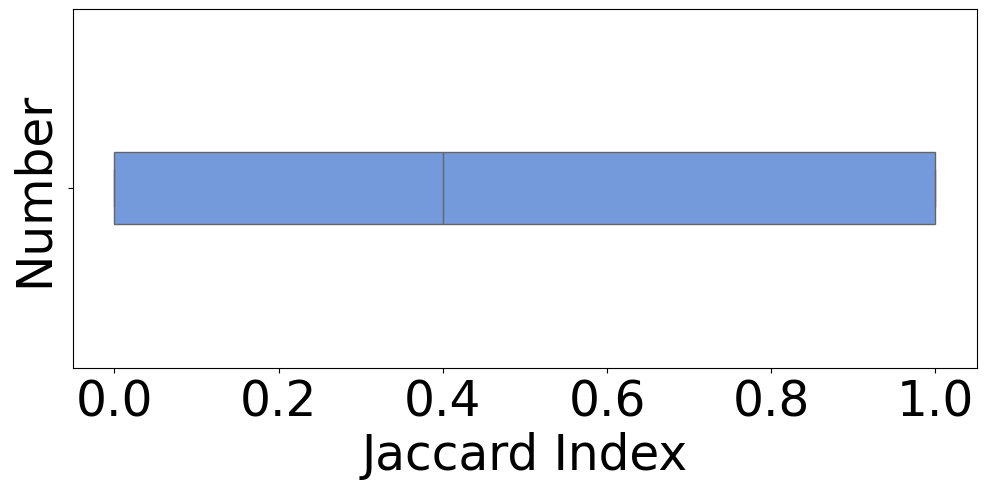

In [5]:
print(program_score_list)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
import seaborn as sns
sns.boxplot(x=program_score_list, width=0.2, color="cornflowerblue")
plt.xticks(rotation=0, fontsize=35)
plt.yticks(fontsize=20)
plt.xlabel('Jaccard Index', fontsize=35)
plt.ylabel('Number', fontsize=35)
plt.tight_layout()
plt.savefig('gpt4_jacard_program.pdf')

In [38]:

print(np.mean(score_list))

0.2581699346405229


In [39]:
print(score_list)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.0, 1.0, 0, 1.0, 1.0, 1.0, 0.0, 0, 0, 0.3333333333333333, 0.5, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.5, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.5, 0.0, 0.0, 1.0, 0.5, 0.5, 0.0, 0.0, 1.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 1.0, 1.0, 0.0, 0.0, 0.25, 0.25, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

/tmp/ipykernel_4005140/3510938517.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=score_list, width=0.3, alpha=0.8, palette=['blue', 'orange', 'green', 'red'])


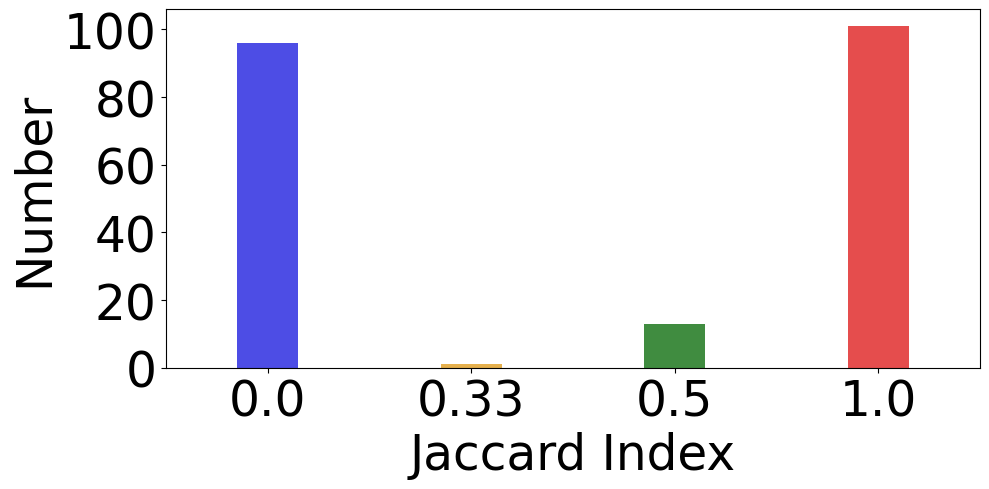

In [6]:
score_list = [ float("{:.2f}".format(x)) for x in score_list ]
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=score_list, width=0.3, alpha=0.8, palette=['blue', 'orange', 'green', 'red'])

# Set font sizes for x and y ticks
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)

# Set labels with fontsize
plt.xlabel('Jaccard Index', fontsize=35)
plt.ylabel('Number', fontsize=35)

# Adjust layout for tight fit
plt.tight_layout()
plt.savefig('gpt4_jacard.pdf')

In [ ]:
#  
#  variable  jaccard_score
# 
#    - pointer type 
# 